# Resources

This is a library of classes and functions which I often employ in simulations and numerical work. The classes (and occasional function) are organized alphabetically by titled section (within each section, the classes themselves are organized by importance/inheritance, as needed).

The classes included in Resources are used by many different projects and are gathered one place for convenience. Specific significant classes (such as the Gothic class) get their own library files. 

***NOTE:*** If at all possible, please add to the "resources.py" file by updating *this* Resources.ipynb file and then manually exporting to the "resources.py" file in the same directory (and then, of course, opening a Python command prompt and executing "import resources" to overwrite and update the "resource.pyc" file, which is ultimately used by import commands in other Python programs). 

Note, finally,  that this is a cleaned-up and pared-down version of my original "resources.py" file, which may still be found in "resources_backup.py."

In [1]:
# Import required Python libraries
from __future__ import division     # In Python 3.x this will not be needed.
import math
import numpy as np
from warnings import warn
import scipy.stats as stats
from scipy.integrate import quad
from numpy.random import RandomState
from scipy.interpolate import interp1d
import pylab as plt


from numpy import log, exp # For ease of reading in get_improved_grid

## Discrete Approximation to a Continuous Distribution

This implements a Python version of the discrete approximation code used in Carroll's Microeconomic DSOP notes. 

In [2]:
class DiscreteApproximation(object):
        
    def __init__(self, N, cdf, pdf, invcdf, precise_summation=False):
        """
        Given a cdf, pdf, and invererse cdf, and number of evenly-spaced bins
        (a partition) of a state space, find the conditional expected values 
        of each evenly-sized partition,  E[X|partition]
        
        An equidistant grid is imposed upon the [0,1] range, and the inverse cdf 
        is employed to determine the appropriate "bin cutoffs." 
                
        The cdf, pdf, and inverse cdf need to be "frozen" distributions -- they 
        need to have their parameters already set and only accept one value to 
        produce output.  

        Note that the MATLAB version has a manually-entered minpoint and maxpoint. 
        These numbers, used "raw" as an upper bound in the Fortran QUADPACK 
        automatic integration function (which is used by both Numpy and Octave, 
        as well as many others) cause numerical instability in the solution. 
        
        The solution is to use np.inf as the upper bound, which happens 
        automatically when the state cutoffs are determined. The np.inf values
        forces correct evaluation of the integral.
        For more details please see discussion in this stackoverflow:
        http://stackoverflow.com/questions/24003694/discontinuity-in-results-when-using-scipy-integrate-quad
        """
        self.cdf = cdf
        self.pdf = pdf
        self.invcdf = invcdf
        self.N = N      # Number of bins
        probs_cutoffs = np.arange(N+1)/N        # Includes 0 and 1
        state_cutoffs = invcdf(probs_cutoffs)   # State cutoff values, each bin
        #bin_probs = np.diff(probs_cutoffs)      # Total prob mass, each bin
        bin_probs = np.zeros(N)
    
        # Find the E[X|bin] values:
        F = lambda x: x*self.pdf(x)
        Ebins = []
        for i, (x0, x1) in enumerate(zip(state_cutoffs[:-1], state_cutoffs[1:])):
            bin_probs[i] = cdf(x1) - cdf(x0) ## pdf between x0 and x1 
            cond_mean, err = quad(F, x0, x1)
            Ebins.append(cond_mean/bin_probs[i])

        self.X = np.array(Ebins)
        self.pmf = bin_probs

        self.precise_summation = precise_summation
        

    def E(self, f=None):
        """
        Find expectation of f(X) over the discrete space.
        """
        if f is None:
            if self.precise_summation:
                return math.fsum(self.pmf * self.X)  # High precision
            else:
                return self.pmf.dot(self.X)          # ~100x faster
        else:
            if self.precise_summation:
                return math.fsum(np.multiply(self.pmf, f(self.X))) # High precision
            else:
                return self.pmf.dot(f(self.X))                     # ~100x faster


    def plot(self, x0, x1, gridsize=100):
        """
        Plot the discrete approximation against the actual distribution.
        """
        grid = np.linspace(x0, x1, gridsize)        
        
        plt.plot(self.X, self.cdf(self.X), 'ok')
        plt.plot(grid, self.cdf(grid), 'k-')
        plt.axis([x0, x1, 0, 1])
        plt.hlines(self.pmf.cumsum(),x0, x1,color ="black",linestyles='--') ## added by Tao to show equiprobable ranges
        plt.title('Discrete Approximation to Lognormal Distribution')
        plt.xlabel('theta')
        plt.ylabel('CDF')
        plt.grid()
        plt.show()

## A Specific Discrete Approximation to the Mean-one lognormal:

Now we use simple inheritance to create a mean-one lognormal instance quickly and easily.

In [3]:
class DiscreteApproximationToMeanOneLogNormal(DiscreteApproximation):
    """
    Extension of the DiscreteApproximation class, which creates a mean-one 
    lognormal approximation, given standard deviation 'sigma' and number 
    of grid-points 'N'.
    """
    
    def __init__(self, N, sigma, precise_summation=False):
        """
        Given N and sigma, create a lognormal "frozen" distribution object,
        and initilize an appropriate DiscreteApproximation.
                
        N:      integer, number of grid points to interpolate over
        sigma:  double, standard deviation of the lognormal distribution
        """
        
        # Save the one bit of new information (N saved in super()):
        self.sigma = sigma
        self.mu = -0.5*(self.sigma**2) 

        # Set up the "frozen" lognormal:
        distrib = stats.lognorm(self.sigma, 0, np.exp(self.mu)) 
        
        # Create the class:
        super(DiscreteApproximationToMeanOneLogNormal, self).__init__(
                N, distrib.cdf, distrib.pdf, distrib.ppf,
                precise_summation=precise_summation)
        
        # Everything is done now. 


In [4]:
# Testing:
if __name__ == "__main__":
    import numpy as np
    import pylab as plt
    from warnings import warn
    from scipy.integrate import quad
    from numpy.random import RandomState
    from scipy.interpolate import interp1d
    import scipy.stats as stats
    from copy import deepcopy

    # Create a 2-D discrete approximation instance:
    sigma = 0.1
    N = 7
    
    LNDiscApprox = DiscreteApproximationToMeanOneLogNormal(N, sigma)
    
    print("LNDiscApprox.E():"+ str(LNDiscApprox.E()))
    # Check that "raw expectation" is correct:
    assert np.max(np.abs(LNDiscApprox.E() - 1.0)) < 1e-16, "Unconditional expectation is not correct!"
    print("Success: Unconditional expectation is correct!")
    
    # Check that the expectation applied to a misc function is correct:
    # Manually, the 7-point approximation for each gridpoint should be:
    manual_X = np.array([ 0.85043016002691718125,  0.91862318529875575113,
        0.95908470592906813756,  0.99506598629571241243,
        1.03241349447674446438,  1.0779763032188010019 ,
        1.16640616475400205054])
    manual_p = np.repeat(1.0/7, 7)

    # Check for a random function: 
    g = lambda x1: x1**2 + 1.5
    
    # Manually construct the expectation of g:
    manual_EgX = 0.0
    for x, p in zip(manual_X, manual_p):
        manual_EgX += g(x) * p
            
    # Now compare manual value against vectorized:
    EgX = LNDiscApprox.E(g)
      
    #print "manual_EgXY:", manual_EgXY
    #print "EgXY:", EgXY
    
    assert np.abs(manual_EgX - EgX) < 1e-12,"Eg(X) not equal between the values that have expectations."
    print("Success: Eg(X) = manually calculated values.")
    print("All tests passed successfully.")
    
    LNDiscApprox.plot(0.7, 1.4)
    
    # Comparing to the 0630 Matlab definition:
    matsig = np.array([0.509520331925153, 0.667826497278589, 0.776380649071803, 0.879396570886877, 0.989752424342583, 1.121403448305962, 1.305157824866014, 1.750562243647017])
    matN   = 8

LNDiscApprox.E():1.0
Success: Unconditional expectation is correct!
Success: Eg(X) = manually calculated values.
All tests passed successfully.


## Discrete Approximation to Two Independent Continuous Distributions

A discrete approximation which neatly bundles two independent continuous distributions into a single discrete approximation object. This "buys" the user a simple expectations operator. 

Further below we will include a simple extension to automatically set up two mean-one lognormal approximations, and two log-normal approximations with discrete probability of a 0-valued event. 


In [1]:
class DiscreteApproximationTwoIndependentDistribs(object):
        
    def __init__(self, N1, cdf1, pdf1, invcdf1, N2, cdf2, pdf2, invcdf2, precise_summation=False):
        """
        Given a cdf, pdf, and invererse cdf, and number of evenly-spaced bins
        (a partition) of a state space, find the conditional expected values 
        of each evenly-sized partition,  E[X|partition]
        
        An equidistant grid is imposed upon the [0,1] range, and the inverse cdf 
        is employed to determine the appropriate "bin cutoffs." 
                
        The cdf, pdf, and inverse cdf need to be "frozen" distributions -- they 
        need to have their parameters already set and only accept one value to 
        produce output.  

        Note that the "first" distribution, X1, will be represented as running
        along the first axis of the joined space, while the second distribution,
        X2, will run along the horizontal axis. 
        
        We will take:
        X1 = xrow = [a, b]
        X2 = ycol = [d, e, f]
        
        we want:
            x_mesh =  [[a, a, a],
                       [b, b, b]]

            y_mesh =  [[d, e, f],
                       [d, e, f]]

        to represent the joint distribution.
        
        
        Note 2: the MATLAB version has a manually-entered minpoint and maxpoint. 
        These numbers, used "raw" as an upper bound in the Fortran QUADPACK 
        automatic integration function (which is used by both Numpy and Octave, 
        as well as many others) cause numerical instability in the solution. 
        
        The solution is to use np.inf as the upper bound, which happens 
        automatically when the state cutoffs are determined. The np.inf values
        forces correct evaluation of the integral.
        
        
        """
        
        self.precise_summation = precise_summation  
        # Used to implement very high-precision calculation of the expected value. Good 
        # for summations of very big, very small, or very close-to-zero numbers. 
        
        # ------ Set up first discrete approx ------
        self.cdf1 = cdf1
        self.pdf1 = pdf1
        self.invcdf1 = invcdf1
        self.N1 = N1      # Number of bins

        probs_cutoffs1 = np.arange(N1+1.0)/N1        # Includes 0 and 1
        state_cutoffs1 = invcdf1(probs_cutoffs1)   # State cutoff values, each bin
        bin_probs1 = np.zeros(N1)
        
        # Find the E[X|bin] values:
        F1 = lambda x: x*self.pdf1(x)
        Ebins1 = []
        for i, (x0, x1) in enumerate(zip(state_cutoffs1[:-1], state_cutoffs1[1:])):
            bin_probs1[i] = cdf1(x1) - cdf1(x0)
            cond_mean1, err1 = quad(F1, x0, x1)
            Ebins1.append(cond_mean1/bin_probs1[i])

        self.X1 = np.array(Ebins1)
        self.pmf1 = bin_probs1

        
        # ------ Set up second discrete approx ------
        self.cdf2 = cdf2
        self.pdf2 = pdf2
        self.invcdf2 = invcdf2
        self.N2 = N2      # Number of bins

        probs_cutoffs2 = np.arange(N2+1.0)/N2        # Includes 0 and 1
        state_cutoffs2 = invcdf2(probs_cutoffs2)   # State cutoff values, each bin
        bin_probs2 = np.zeros(N2)
        
        # Find the E[X|bin] values:
        F2 = lambda x: x*self.pdf2(x)
        Ebins2 = []
        for i, (x0, x1) in enumerate(zip(state_cutoffs2[:-1], state_cutoffs2[1:])):
            bin_probs2[i] = cdf2(x1) - cdf2(x0)
            cond_mean2, err2 = quad(F2, x0, x1)
            Ebins2.append(cond_mean2/bin_probs2[i])

        self.X2 = np.array(Ebins2)
        self.pmf2 = bin_probs2
        
        '''
        For
            xrow = [a, b]
            ycol = [d, e, f]
        
        we want:
            x_mesh =  [[a, a, a],
                       [b, b, b]]

            y_mesh =  [[d, e, f],
                       [d, e, f]]
                 
        '''
        
        # Now construct the X1/X2 mesh values: 
        nrow = len(self.X1)
        ncol = len(self.X2)
        
        # We don't use the np.meshgrid commands, because they do not 
        # easily support non-symmetric grids.
        self.X1mesh,self.X2mesh = np.meshgrid(self.X1,self.X2)
        self.X1mesh = self.X1mesh.T   
        self.X2mesh = self.X2mesh.T
        #self.X1mesh = np.tile(np.transpose([self.X1]), (1, ncol))
        #self.X2mesh = np.tile(self.X2, (nrow, 1))

        # Construct the appropriate probability for each point:
        self.pmf = np.zeros_like(self.X1mesh)
        # Loop to fill in probs:
        for i, p1 in enumerate(self.pmf1):
            for j, p2 in enumerate(self.pmf2):
                self.pmf[i,j] = p1*p2 
        
        # Create flat versions of all these:
        self.flatX1 = self.X1mesh.ravel()
        self.flatX2 = self.X1mesh.ravel()
        self.flatpmf = self.pmf.ravel()
        
        # Check that sums to 1:
        #print "np.sum(self.pmf):", np.sum(self.pmf) 
        assert np.abs(np.sum(self.pmf) - 1.0) < 1e-10, "Total 2D pmf doesn't sum to 1." 
        

    def condE1(self, x2, f=None):
        pass

        
    def E(self, f=None):
        """
        Find the expectation of f over X1, X2.
        
        Note f must work for being applied to a grid of values. 
        """
        if f is None:
            # Return simple conditional expectation.
            
            if self.precise_summation:
                return( np.array( [math.fsum(self.pmf1 * self.X1), math.fsum(self.pmf2 * self.X2)] ) )
            else:
                return( np.array( [self.pmf1.dot(self.X1), self.pmf2.dot(self.X2)] ) ) 
            
        else:
            fval = f(self.X1mesh, self.X2mesh)
            #fval = f(self.flatX1, self.flatX2)
            a = np.multiply(self.pmf, fval)
            if self.precise_summation:
                return(math.fsum(a))    # High-floating-point precision summation.
            else:
                return( np.sum(a) )             # 100x faster C summation
            # np.multiply works the same for both numpy arrays and matrices; 
            # potentially important if for some reason, f takes an array and 
            # returns a matrix. Likely uncommon, but just want to be safe. 
                                                

    def plot(self, x0, x1, x20, x21, gridsize=100):
        """
        Plot the discrete approximation against the actual distribution.
        """
        grid = np.linspace(x0, x1, gridsize)        
        
        plt.plot(self.X1, self.cdf1(self.X1), 'ok')
        plt.plot(grid, self.cdf1(grid), 'k-')
        plt.hlines(self.pmf1.cumsum(),x0, x1,color ="black",linestyles='--') ## added by Tao to show equiprobable ranges
        plt.axis([x0, x1, 0, 1])
        plt.title('Discrete Approximation to Lognormal Distribution')
        plt.xlabel('theta')
        plt.ylabel('CDF')
        plt.grid()
        plt.show()

        grid = np.linspace(x20, x21, gridsize)        
        
        plt.plot(self.X2, self.cdf2(self.X2), 'ok')
        plt.plot(grid, self.cdf2(grid), 'k-')
        plt.hlines(self.pmf2.cumsum(),x0, x1,color ="black",linestyles='--') ## added by Tao to show equiprobable ranges
        plt.axis([x20, x21, 0, 1])
        plt.title('Second Discrete Approximation to Lognormal Distribution')
        plt.xlabel('theta')
        plt.ylabel('CDF')
        plt.grid()
        plt.show()

(7, 8)


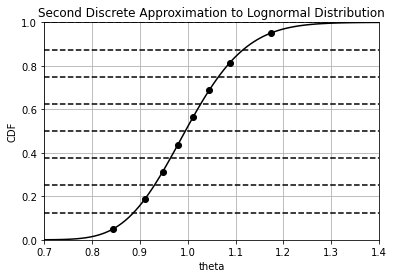

In [3]:
# Immediately run some tests.
# Note that this will not run unless this is executed as the "main" file. 
if __name__ == "__main__":
    import numpy as np
    import pylab as plt
    from warnings import warn
    from scipy.integrate import quad
    from numpy.random import RandomState
    from scipy.interpolate import interp1d
    import scipy.stats as stats
    from copy import deepcopy

    # Create a 2-D discrete approximation instance:
    sigma1 = 0.1
    mu1 = -0.5*(sigma1**2)
    N1 = 7
    z1 = stats.lognorm(sigma1, 0, np.exp(mu1))  # Create "frozen" distribution instance

    sigma2 = 0.1
    mu2 = -0.5*(sigma2**2)
    N2 = 8
    z2 = stats.lognorm(sigma2, 0, np.exp(mu2))  # Create "frozen" distribution instance
    
    TwoDimDiscApprox = DiscreteApproximationTwoIndependentDistribs(N1, z1.cdf, z1.pdf, z1.ppf, N2, z2.cdf, z2.pdf, z2.ppf)
    
    
    # Check that "raw expectation" is correct:
    assert np.max(np.abs(TwoDimDiscApprox.E() - 1.0)) < 1e-16, "Unconditional expectation is not correct!"
    
    # Check that the expectation applied to a misc function is correct:
    # Manually, the 7-point approximation for each gridpoint should be:
    manual_X1 = np.array([ 0.85043016002691718125,  0.91862318529875575113,
        0.95908470592906813756,  0.99506598629571241243,
        1.03241349447674446438,  1.0779763032188010019 ,
        1.16640616475400205054])
    manual_p1 = np.repeat(1.0/7, 7)

    manual_X2 = deepcopy(manual_X1)
    manual_p2 = np.repeat(1.0/7, 7)

    # Check for a random function: 
    g = lambda x1, x2: x1**2 + 1.5*x2
    
    # Manually construct the expectation of g:
    manual_EgXY = 0.0
    for x1, p1 in zip(manual_X1, manual_p1):
        for x2, p2 in zip(manual_X2, manual_p2):
           manual_EgXY += g(x1, x2) * p1 * p2
            
    # Now compare manual value against vectorized:
    EgXY = TwoDimDiscApprox.E(g)
      
    #print "manual_EgXY:", manual_EgXY
    #print "EgXY:", EgXY
        
    assert np.abs(manual_EgXY - EgXY) < 1e-12, "Eg(X,Y) not equal between the values that have expectations."

    TwoDimDiscApprox.plot(0.7, 1.4, 0.7, 1.4)

In [58]:
class DiscreteApproximationTwoMeanOneIndependentLognormalDistribs(DiscreteApproximationTwoIndependentDistribs):
    """
    Extend the "DiscreteApproximationTwoIndependentDistribs" to automatically define a 
    lognormal, mean 1 distribution. 
    
    Nathan Palmer
    """
    
    def __init__(self, N1, sigma1, N2, sigma2, precise_summation=False):
        """
        Given N1, sigma1, N2, sigma2, create two lognormal "frozen" distributions,
        and initilize an appropriate DiscreteApproximationTwoIndependentDistribs.
        
        Very simple inheritance exercise.
                
        N1:      integer, number of grid points to interpolate over for distrib 1
        sigma1:  double, standard deviation of the first lognormal distribution
        N2:      integer, number of grid points to interpolate over for distrib 2
        sigma2:  double, standard deviation of the second lognormal distribution
        """
        
        # Save the one bit of new information (N saved in super()):
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        
        # Set up the "frozen" lognormals:
        self.mu1 = -0.5*(self.sigma1**2) 
        distrib1 = stats.lognorm(self.sigma1, 0, np.exp(self.mu1)) 

        self.mu2 = -0.5*(self.sigma2**2) 
        distrib2 = stats.lognorm(self.sigma2, 0, np.exp(self.mu2)) 

        # Create the class:
        super(DiscreteApproximationTwoMeanOneIndependentLognormalDistribs, self).__init__(
            N1=N1, cdf1=distrib1.cdf, pdf1=distrib1.pdf, invcdf1=distrib1.ppf, 
            N2=N2, cdf2=distrib2.cdf, pdf2=distrib2.pdf, invcdf2=distrib2.ppf, 
            precise_summation=precise_summation)
    

#DiscreteApproximationTwoMeanOneIndependentLognormalDistribsWithDiscreteProb_0_Event


M1 and Mu2 were both calculated correctly!
Unconditional expectation *is* correct: E(X1, X2) =[1. 1.]
Eg(X,Y) *does* equal manually calculated joint value:
	E[g(X1, X2)] from class:2.509359096990949
	and from manual calc:2.509359096990949
	np.abs(manual_EgXY - EgXY):0.0


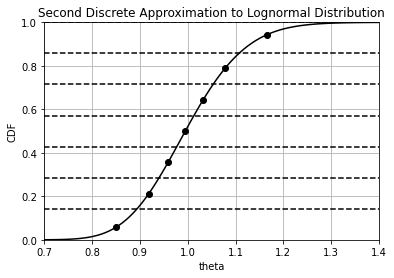

In [63]:
# Immediately run some tests.
# Note that this will not run unless this is executed as the "main" file. 
if __name__ == "__main__":
    import numpy as np
    import pylab as plt
    from warnings import warn
    from scipy.integrate import quad
    from numpy.random import RandomState
    from scipy.interpolate import interp1d
    import scipy.stats as stats
    from copy import deepcopy

    # Create a 2-D discrete approximation instance:
    sigma1 = 0.1
    mu1 = -0.5*(sigma1**2)
    N1 = 7
    z1 = stats.lognorm(sigma1, 0, np.exp(mu1))  # Create "frozen" distribution instance

    sigma2 = 0.1
    mu2 = -0.5*(sigma2**2)
    N2 = 7
    z2 = stats.lognorm(sigma2, 0, np.exp(mu2))  # Create "frozen" distribution instance
    
    TwoDimDiscApprox = DiscreteApproximationTwoMeanOneIndependentLognormalDistribs(
                        N1=N1, sigma1=sigma1, N2=N2, sigma2=sigma2)
    
    
    # Check that mu calculated correctly:
    assert np.max(np.abs(TwoDimDiscApprox.mu1 - mu1)) < 1e-16, "Mu1 not calculated correctly!"
    assert np.max(np.abs(TwoDimDiscApprox.mu2 - mu2)) < 1e-16, "Mu2 not calculated correctly!"
    print("M1 and Mu2 were both calculated correctly!")  
    
    # Check that "raw expectation" is correct:
    assert np.max(np.abs(TwoDimDiscApprox.E() - 1.0)) < 1e-16, "Unconditional expectation is not correct!"
    print("Unconditional expectation *is* correct: E(X1, X2) ="+str(TwoDimDiscApprox.E()))
    
    # Check that the expectation applied to a misc function is correct:
    # Manually, the 7-point approximation for each gridpoint should be:
    manual_X1 = np.array([ 0.85043016002691718125,  0.91862318529875575113,
        0.95908470592906813756,  0.99506598629571241243,
        1.03241349447674446438,  1.0779763032188010019 ,
        1.16640616475400205054])
    manual_p1 = np.repeat(1.0/7, 7)

    manual_X2 = deepcopy(manual_X1)
    manual_p2 = np.repeat(1.0/7, 7)

    # Check for a random function: 
    g = lambda x1, x2: x1**2 + 1.5*x2
    
    # Manually construct the expectation of g:
    manual_EgXY = 0.0
    for x1, p1 in zip(manual_X1, manual_p1):
        for x2, p2 in zip(manual_X2, manual_p2):
           manual_EgXY += g(x1, x2) * p1 * p2
            
    # Now compare manual value against vectorized:
    EgXY = TwoDimDiscApprox.E(g)
      
    #print "manual_EgXY:", manual_EgXY
    #print "EgXY:", EgXY
        
    assert np.abs(manual_EgXY - EgXY) < 1e-12, "Eg(X,Y) not equal manually calculated joint value."
    print("Eg(X,Y) *does* equal manually calculated joint value:")
    print("\tE[g(X1, X2)] from class:"+ str(EgXY)+ "\n\tand from manual calc:"+ str(manual_EgXY)
          + "\n\tnp.abs(manual_EgXY - EgXY):"+str(np.abs(manual_EgXY - EgXY)))
    
    TwoDimDiscApprox.plot(0.7, 1.4, 0.7, 1.4)

In [71]:
class DiscreteApproximationToTwoMeanOneIndependentLognormalDistribsWithDiscreteProb_Z_Event(DiscreteApproximationTwoMeanOneIndependentLognormalDistribs):
    """
    ----------------------------------------------------------------------------
    Extend the "DiscreteApproximationTwoMeanOneIndependentLognormalDistribs" 
    class by introducing a discrete probability of a discrete-valued event occuring 
    for the second random variable, with value "z."
    
    The second variable experiences a z-event with probability pZevent. If the 
    state vector for the second random variable, X2, already includes a z value, 
    no changes are made (and a warning is raised). 
    
    Otherwise the state vector X2 is prepended with z, and all *other* 
    values of X2 are set to X2/(1-pZevent).

    The probability vector pmf2 is prepended with pZevent, and all other 
    pmf2 are set to pmf2*(1-pZevent).
    
    Finally, the state-space is re-determined and the total pmf matrix, 
    "pmf", is re-calcualted with the new values. 
    
    All other methods should function the same as before.
    This is still a relatively simple example of multiple inheritance. 
    """
    
    def __init__(self, N1, sigma1, N2, sigma2, pZevent, z=0.0, precise_summation=False):
        
        # Execute the initilizer for parent own class:
        super(DiscreteApproximationToTwoMeanOneIndependentLognormalDistribsWithDiscreteProb_Z_Event, self).__init__(
            N1=N1, sigma1=sigma1, N2=N2, sigma2=sigma2, precise_summation=precise_summation)
        
        self.pZevent = pZevent
        
        if not 0 <= pZevent <= 1:
            raise Exception("The probability that discrete event z = "+ z +" has a probability not in the range [0,1]: pZevent = "+str(pZevent))
        
        # Update X2 vector:
        if z in self.X2:
            warn("Discrete shock value "+ z +" already exists in the RV discrete space self.X2. Please confirm that inputs are correct")
        else:
            self.X2 = np.append(z, self.X2/(1.0 - pZevent))
            
        # Update pmf2:
        self.pmf2 = np.append(pZevent, self.pmf2 * (1.0 - pZevent))
        
        # Update total state-space:
        nrow = len(self.X1)
        ncol = len(self.X2)
        
        # We don't use the np.meshgrid commands, because they do not 
        # easily support non-symmetric grids.
        self.X1mesh = np.tile(np.transpose([self.X1]), (1, ncol))
        self.X2mesh = np.tile(self.X2, (nrow, 1))

        # Construct the appropriate probability for each point:
        self.pmf = np.zeros_like(self.X1mesh)
        
        # Loop to fill in probs:
        for i, p1 in enumerate(self.pmf1):
            for j, p2 in enumerate(self.pmf2):
                self.pmf[i,j] = p1*p2
        
        # Flat versions:
        self.flatX1 = self.X1mesh.ravel()
        self.flatX2 = self.X2mesh.ravel()
        self.flatpmf = self.pmf.ravel()

        # Check that sums to 1:
        #print "np.sum(self.pmf):", np.sum(self.pmf) 
        assert np.abs(np.sum(self.pmf) - 1.0) < 1e-10, "Total 2D pmf doesn't sum to 1." 
        
        

M1 and Mu2 were both calculated correctly!
TwoDimDiscApprox.E()[ 1. 51.]
Manual E[(X1, X2)][ 1. 51.]
max(abs(diff)):0.0
Unconditional expectation *is* correct: E(X1, X2) =
	From class:[ 1. 51.]
	Manual calc:[ 1. 51.]
TwoDimDiscApprox.E(g)77.50935909699095
Manual E[g(X1, X2)]77.50935909699095
max(abs(diff)):0.0
Eg(X,Y) *does* equal manually calculated joint value:
	E[g(X1, X2)] from class:77.50935909699095s
	and from manual calc:77.50935909699095


<ipython-input-73-e9b4fa8dcb31>:105: UserWarning: 

NOTE: There is a very small difference between the manual and Numpy-summed calculation of the e[g(X1,X2)]. 1e-15, but still there, and not 1e-16. Very mild concern -- but only if this grows with increasing numbers.


  warn("\n\nNOTE: There is a very small difference between the manual and Numpy-summed calculation of the e[g(X1,X2)]. 1e-15, but still there, and not 1e-16. Very mild concern -- but only if this grows with increasing numbers.\n\n")
<ipython-input-73-e9b4fa8dcb31>:107: UserWarning: 

UPDATE NOTE: this problem was entirely solved by using math.fsum() to conduct high-precision summation. The trouble: math.fsum is 100x slower than np.sum(). Use precise_summation=True to see this version work.
  warn("\n\nUPDATE NOTE: this problem was entirely solved by using math.fsum() to conduct high-precision summation. The trouble: math.fsum is 100x slower than np.sum(). Use precise_summation=True to see this version work.")


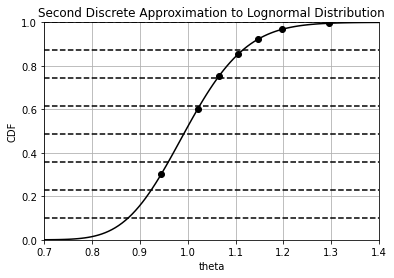

In [73]:
# Immediately run some tests.
# Note that this will not run unless this is executed as the "main" file. 
if __name__ == "__main__":
    import numpy as np
    import pylab as plt
    from warnings import warn
    from scipy.integrate import quad
    from numpy.random import RandomState
    from scipy.interpolate import interp1d
    import scipy.stats as stats
    from copy import deepcopy

    # Create a 2-D discrete approximation instance:
    sigma1 = 0.1
    mu1 = -0.5*(sigma1**2)
    N1 = 7
    z1 = stats.lognorm(sigma1, 0, np.exp(mu1))  # Create "frozen" distribution instance

    sigma2 = 0.1
    mu2 = -0.5*(sigma2**2)
    N2 = 7
    z2 = stats.lognorm(sigma2, 0, np.exp(mu2))  # Create "frozen" distribution instance
    
    # Define a "z" event:
    prob_Z_event = 0.1   # If we push this to 0.5 or 0.999, we'll see the "error" between manaual and numpy calc grow ~1e-15 to 1e-13 or 1e-14
    z_value = 500.0      # Same here; as we increase order of magnitude, we'll see "error" between manual and numpy calc grow. 
                         # See user warning below. 
        
                         # UPDATE: NOTE that this problem was entirely solved by using math.fsum() to conduct high-precision summation.
    
    TwoDimDiscApproxZ = DiscreteApproximationToTwoMeanOneIndependentLognormalDistribsWithDiscreteProb_Z_Event(
                        N1=N1, sigma1=sigma1, N2=N2, sigma2=sigma2, 
                        pZevent=prob_Z_event, z=z_value, precise_summation=True)
    # Try precise_summation=False to see errors emerge. 
    
    # Check that mu calculated correctly:
    assert np.max(np.abs(TwoDimDiscApproxZ.mu1 - mu1)) < 1e-16, "Mu1 not calculated correctly!"
    assert np.max(np.abs(TwoDimDiscApproxZ.mu2 - mu2)) < 1e-16, "Mu2 not calculated correctly!"
    print("M1 and Mu2 were both calculated correctly!")
    
    # Check that the expectation applied to a misc function is correct:
    # Manually, the 7-point approximation for each gridpoint should be:
    manual_X1 = np.array([ 0.85043016002691718125,  0.91862318529875575113,
        0.95908470592906813756,  0.99506598629571241243,
        1.03241349447674446438,  1.0779763032188010019 ,
        1.16640616475400205054])
    manual_p1 = np.repeat(1.0/7, 7)

    manual_X2 = deepcopy(manual_X1)
    manual_p2 = np.repeat(1.0/7, 7)
    
    # Manually adjust X2 for the 0-valued event:
    manual_X2 = np.append(z_value, manual_X2/(1.0-prob_Z_event))
    manual_p2 = np.append(prob_Z_event, manual_p2*(1.0-prob_Z_event))

    # Manually calculate the unconditional expectation:
    #manual_EX1 = np.dot(manual_X1, manual_p1)
    #manual_EX2 = np.dot(manual_X2, manual_p2)
    manual_EX1 = math.fsum(manual_X1*manual_p1)
    manual_EX2 = math.fsum(manual_X2*manual_p2)
    manual_EX = np.array([manual_EX1, manual_EX2])
    
    # Check that "raw expectation" is correct:
    print("TwoDimDiscApprox.E()"+ str(TwoDimDiscApproxZ.E()))
    print("Manual E[(X1, X2)]"+str(manual_EX))
    print("max(abs(diff)):"+str(np.max(np.abs(TwoDimDiscApproxZ.E() - manual_EX))))
    # This is the value we "know" it should be, for a shock of 0.0:
    #assert np.max(np.abs(TwoDimDiscApprox.E() - 1.0)) < 1e-16, "Unconditional expectation is not correct for a shock value of 0!"
    #print "Unconditional expectation *is* correct: E(X1, X2) =", TwoDimDiscApprox.E()
 
    # With the manually calculated value:
    assert np.max(np.abs(TwoDimDiscApproxZ.E() - manual_EX)) < 1e-12, "Unconditional expectation is not correct!"
    print("Unconditional expectation *is* correct: E(X1, X2) =\n\tFrom class:"+ str(TwoDimDiscApproxZ.E())+ "\n\tManual calc:"+ str(manual_EX))
 
    
    # Check for a random function: 
    g = lambda x1, x2: x1**2 + 1.5*x2
    
    # Manually construct the expectation of g:
    #manual_EgXY = 0.0
    temp_manual_EgXY = []
    for x1, p1 in zip(manual_X1, manual_p1):
        for x2, p2 in zip(manual_X2, manual_p2):
            #manual_EgXY += g(x1, x2) * p1 * p2
            temp_manual_EgXY.append(g(x1, x2) * p1 * p2)
            
    manual_EgXY = math.fsum(temp_manual_EgXY)
            
    # Now compare manual value against vectorized:
    EgXY = TwoDimDiscApproxZ.E(g)
      
    #print "manual_EgXY:", manual_EgXY
    #print "EgXY:", EgXY
    
    print("TwoDimDiscApprox.E(g)"+str(TwoDimDiscApproxZ.E(g)))
    print("Manual E[g(X1, X2)]"+str(manual_EgXY))
    print("max(abs(diff)):"+str(np.max(np.abs(TwoDimDiscApproxZ.E(g) - manual_EgXY))))
    
    
    assert np.abs(manual_EgXY - EgXY) < 1e-16, "Eg(X,Y) not equal manually calculated joint value."
    print("Eg(X,Y) *does* equal manually calculated joint value:")
    print("\tE[g(X1, X2)] from class:"+ str(EgXY)+"s\n\tand from manual calc:"+str(manual_EgXY))

    
    warn("\n\nNOTE: There is a very small difference between the manual and Numpy-summed calculation of the e[g(X1,X2)]. 1e-15, but still there, and not 1e-16. Very mild concern -- but only if this grows with increasing numbers.\n\n")
    # NOTE: This may very well be due to how Numpy can "correct" for precision errors in addition of very small or very large numbers. 
    warn("\n\nUPDATE NOTE: this problem was entirely solved by using math.fsum() to conduct high-precision summation. The trouble: math.fsum is 100x slower than np.sum(). Use precise_summation=True to see this version work.")
    
    TwoDimDiscApproxZ.plot(0.7, 1.4, 0.7, 1.4)

## Discrete Random Variable

A very simple wrapper to provide a discerete random variable with only two values -- "employed" and "unemployed" income.  

In [74]:
class SimpleDiscreteRandomVariable(stats.rv_discrete):
    
    def __init__(self, values, probs, certain_value, name="discrete random variable", precise_summation=False):
        discrete_RV_value_prob = [values, probs]
        self.precise_summation = precise_summation
        super(SimpleDiscreteRandomVariable, self).__init__(min(0,min(values)), np.inf, name, None, 1e-10, discrete_RV_value_prob)
        # stats.rv_discrete(self, a=0, b=inf, name=None, badvalue=None, moment_tol=1e-08, values=None, ...)
        self.certain_value=certain_value
    
    def E(self, f=None):
        """
        Find expectation of f(X) over the discrete space.
        """
        if f is None:
            if self.precise_summation:
                return math.fsum(np.multiply(self.pk, self.xk)) # High precision
            else:
                return self.mean()
        else:
            fX = f(self.certain_value, self.xk)
            if self.precise_summation:
                return math.fsum(np.multiply(self.pk, fX)) # High precision
            else:
                return np.dot(self.pk, fX)                 # ~100x faster

### Testing

Simple testing.

In [80]:
if __name__ == "__main__":

    p=0.0005
    vals = np.array([0.0, 1.0/(1.0-p)])
    probs = np.array([p, 1.0-p])
    
    test = SimpleDiscreteRandomVariable(values=vals, probs=probs, certain_value=1.0, name="discrete random variable", precise_summation=True)
    
    manual_EX = math.fsum(vals*probs)

    # Check that "raw expectation" is correct:
    print("test.E()"+str(test.E()))
    print("Manual E[X]"+ str(manual_EX))
    print("max(abs(diff)):"+str(np.max(np.abs(test.E() - manual_EX))))

    # With the manually calculated value:
    assert np.max(np.abs(test.E() - manual_EX)) < 1e-12, "Unconditional expectation is not correct!"
    print("Unconditional expectation *is* correct: E(X) =\n\tFrom class:"+str(test.E())+"\n\tManual calc:"+str(manual_EX))
 
    # Check for a random function: 
    g = lambda x1, x2: x1**2 + pi*x2  #g = lambda x1: x1**2 + 1.5
    
    # Manually construct the expectation of g:
    temp_manual_EgX = []
    for x1, p1 in zip(vals, probs):
        temp_manual_EgX.append(g(1.0, x1) * p1)
            
    manual_EgX = math.fsum(temp_manual_EgX)
    
    # Now compare manual value against vectorized:
    EgX = test.E(g)
      
    #print "manual_EgXY:", manual_EgXY
    #print "EgXY:", EgXY
    
    print("test.E(g)"+str(test.E(g)))
    print("Manual E[g(X)]"+ str(manual_EgX))
    print("max(abs(diff)):"+str(np.max(np.abs(test.E(g) - manual_EgX))))
    
    
    assert np.abs(manual_EgX - EgX) < 1e-16, "Eg(X) not equal manually calculated joint value."
    print("Eg(X) *does* equal manually calculated joint value:")
    print("\tE[g(X)] from class:"+str(EgX)+"\n\tand from manual calc:"+str(manual_EgX))

TypeError: __new__() got an unexpected keyword argument 'probs'

## Improved Grid

Unlike most other definitions in this library, this is a simple function, not a class. This is implements the multi-exponential grid discussed in Carroll's Microeconomioc DSOP notes. 

In [ ]:
# Note: this is taken almost verbatim from Chris Carroll's original Matlab code
# Define function:
def get_improved_grid(minval, maxval, size): 
    """
    This function finds values on a 1D grid such that the multi-exponential 
    growth rate* from each point to the next is constant (instead of, eg., 
    imposing a constant absolute gap between points).
    
    This is a nearly verbatim translation of Chris Carroll's DSOP code from 
    MATLAB to Python.    

    *That is, exp(exp(exp(...))) for some number of exponentiations n.
    
    Args:
        minval (float):    Minimum grid value.
        maxval (float):    Maximum grid value.
        size (int):        Number of points in the grid.
    Returns:
        new_a_grid (list):    eee-spaced grid.
    Raises:
        []
    """
    gMinMin = 0.01*minval;
    gMaxMax = 10*maxval;
    gridMin = log(1+log(1+log(1+gMaxMax)))
    gridMax = (log(1+log(1+log(1+gMaxMax)))-log(1+log(1+log(1+gMinMin))))/size
    index = log(1+log(1+log(1+gMinMin))) + (log(1+log(1+log(1+gMaxMax)))-log(1+log(1+log(1+gMinMin))))/size
    i = 1
    point = 0
    points = []
    while point < gridMin:
        point = point + indexThis 
        points.append(point)
        i += 1
    
    new_a_grid = exp(exp(exp(points)-1)-1)-1
    return new_a_grid

## Utility functions

Python's object-oriented class structure makes it convenient to define a utility function and bundle with it properties such as the first and second derivative. "Resources" includes definitions for CRRA utility ("Utility") and exponential utility ("UtilityExponential"). 

(Note that I may need to eventually refactor "Utility" to "UtilityCRRA.")

In [5]:
class Utility(object):
    """
    Define a CRRA utility function in levels and 
    in first and second derivative.
    """
    def __init__(self, gamma):
        self.gamma = gamma
        
    def __call__(self, c):
        if self.gamma == 1:
            # Log case:
            return( np.log(c) )
        else:
            # Regular case:
            return( c**(1.0 - self.gamma) / (1.0 - self.gamma) )
        
    def prime(self, c):
        if self.gamma == 1:
            # Log case:
            return(1.0/c)
        else:
            # Regular case:
            return(c**-self.gamma)

    def prime2(self, c):
        if self.gamma == 1:
            # Log case:
            return(-c**(-2.0))
        else:
            # Regular case:
            return(-self.gamma*c**(-self.gamma-1.0))


class UtilityExponential:
    """
    Define an exponential utility function in levels and 
    in first and second derivative.
    """
    def __init__(self, gamma):
        self.gamma = gamma

    def __call__(self, c):
        return( c**self.gamma )

    def prime(self, c):
        return(self.gamma*c**(self.gamma-1.0))

    def prime2(self, c):
        return((self.gamma-1.0)*self.gamma*c**(self.gamma-2.0))

    
class UtilityWithCMin:
    """
    Define a CRRA utility function in levels and in 
    first derivative, with an imposed lower bound on 
    utility (via a lower bound on consumption.) 

    Note that this is not the preferred way to impose
    bounded utility; this is however included here 
    for backwards compatability with some simulations.

    """
    def __init__(self, gamma, cmin):
        self.gamma = gamma
        self.cmin = cmin
        if gamma == 1:
            # Log case:
            self.__call__ = self.call_log
            self.prime = self.prime_log
        else:
            # Regular case:
            self.__call__ = self.call_regular
            self.prime = self.prime_regular

    def prime_regular(self, c):
        """
        The derivative when gamma != 1.
        """
        return(c**-self.gamma)

    def prime_log(self, c):
        """
        The derivative when gamma == 1.
        """
        return(1.0/c)
    
    def call_regular(self, c):
        return( np.maximum(c,self.cmin)**(1.0 - self.gamma) / (1.0 - self.gamma) )

    def call_log(self, c):
        return( np.log(np.maximum(c, self.cmin)) )
